<a href="https://colab.research.google.com/github/ad045/estimating_grid_alignments/blob/main/Sixth_NN_3_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Overarching goal: Using LSTM uses the real ROI to predict data!

## Getting Data and Understanding It

In [ ]:
# !pip install mne_nirs
# import mne_nirs

# !pip install pyts
# import pyts # recurrence plots

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Input, concatenate

from sklearn.preprocessing import MinMaxScaler # object
from sklearn.preprocessing import minmax_scale # function
from sklearn.metrics import mean_squared_error, r2_score


Getting all the input data




File should be a csv file, where the rows are the different time steps and each column stores the data of one voxel of the ROI.
Could have f.e. the path "/content/time_series_run012_ROI.csv"


In [ ]:
num_voxels = 23
voxel_list = ['voxel_' + str(i) for i in range(1, num_voxels+1)]
print(voxel_list)

['voxel_1', 'voxel_2', 'voxel_3', 'voxel_4', 'voxel_5', 'voxel_6', 'voxel_7', 'voxel_8', 'voxel_9', 'voxel_10', 'voxel_11', 'voxel_12', 'voxel_13', 'voxel_14', 'voxel_15', 'voxel_16', 'voxel_17', 'voxel_18', 'voxel_19', 'voxel_20', 'voxel_21', 'voxel_22', 'voxel_23']


In [ ]:
df = pd.read_csv("/content/time_series_run012_ROI.csv", header = None, names=voxel_list)

In [ ]:
df.head()

,voxel_1,voxel_2,voxel_3,voxel_4,voxel_5,voxel_6,voxel_7,voxel_8,voxel_9,voxel_10,...,voxel_14,voxel_15,voxel_16,voxel_17,voxel_18,voxel_19,voxel_20,voxel_21,voxel_22,voxel_23
0,2859,2790,2959,2844,2758,2656,2601,2425,3389,2764,...,2523,2349,2663,2615,2653,2555,2540,2468,2658,2610
1,2854,2762,2956,2820,2711,2628,2555,2401,3394,2721,...,2497,2331,2636,2594,2636,2538,2527,2453,2646,2597
2,2872,2775,2972,2835,2719,2634,2558,2396,3404,2718,...,2494,2325,2620,2581,2629,2529,2519,2446,2623,2584
3,2858,2771,2958,2829,2726,2621,2552,2384,3392,2734,...,2482,2314,2627,2578,2619,2519,2510,2433,2624,2578
4,2857,2764,2956,2825,2713,2624,2548,2394,3394,2718,...,2484,2316,2618,2569,2619,2508,2508,2419,2612,2564


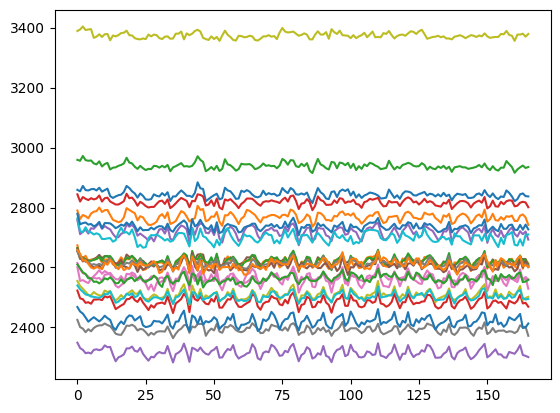

In [ ]:
# plt.plot(df.voxel_1)
plt.plot(df)

Looking at the mean

*(Attention / Change to previous version: All channels need to be normalized FIRST! Otherwise, specific channels will have much higher influence on the mean than others!). The previous code only looked at the absolute difference between mean and fNIRS data.*

In [ ]:
# This code also works! I just was not entirely sure, if it normalizes on every
# column individually or on the dataframe as a whole; and this piece of code came
# until now after the plotting

# scaler = MinMaxScaler()

# # Normalize all values column-wise
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# plt.plot(df)

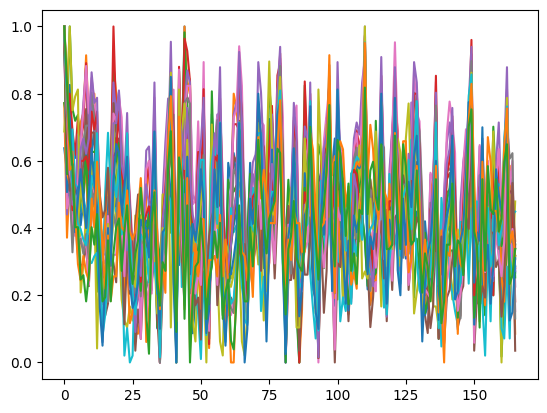

In [ ]:
# Normalize the column
for voxel in voxel_list:
  df[voxel] = minmax_scale(df[voxel])

# Plot the normalized dataframe
plt.plot(df)

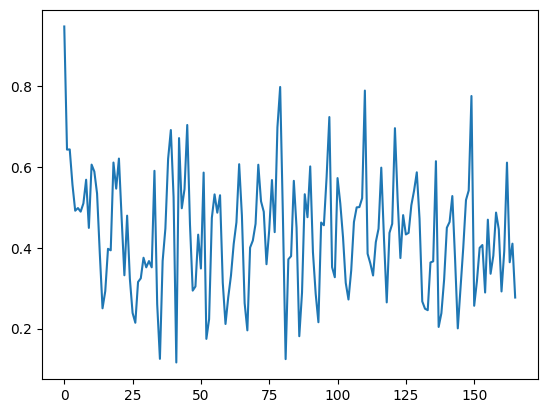

In [ ]:
df['vox_mean'] = np.mean(df, axis=1)
plt.plot(df.vox_mean)

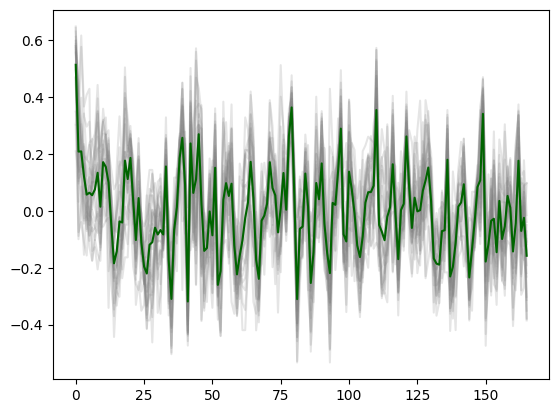

In [ ]:
for col in df.columns:
    col_mean = df[col].mean()
    df[col] = df[col] - col_mean

# plot the resulting values
df.plot(color='gray', alpha=0.2, legend = False)
plt.plot(df.vox_mean, color = "darkgreen")
plt.show()

In [ ]:
# shift column 'vox_mean' by one to the top >> time series effect
df['shifted_mean'] = df['vox_mean'].shift(periods=-1)
# df.drop('vox_mean', axis=1, inplace=True)
df = df.drop(df.index[-1]) #important! Otherwise the code does not work ("NaN" in array trips up mse...)

# normalize
# df_normalized.plot(color='gray', alpha=0.1, legend = False)
# plt.plot(df_normalized.shifted_mean, color = "lightgreen")
# plt.plot(df_normalized.vox_mean, color = "darkgreen")


## Create a shifted mean
The LSTM streams work on different columns of the data frame


In [ ]:
voxel_list

['voxel_1',
 'voxel_2',
 'voxel_3',
 'voxel_4',
 'voxel_5',
 'voxel_6',
 'voxel_7',
 'voxel_8',
 'voxel_9',
 'voxel_10',
 'voxel_11',
 'voxel_12',
 'voxel_13',
 'voxel_14',
 'voxel_15',
 'voxel_16',
 'voxel_17',
 'voxel_18',
 'voxel_19',
 'voxel_20',
 'voxel_21',
 'voxel_22',
 'voxel_23']

In [ ]:
current_df = pd.DataFrame()
for voxel in voxel_list:
  current_df[voxel] = df[voxel].copy()

current_df['shifted_mean'] = df['shifted_mean'].copy()

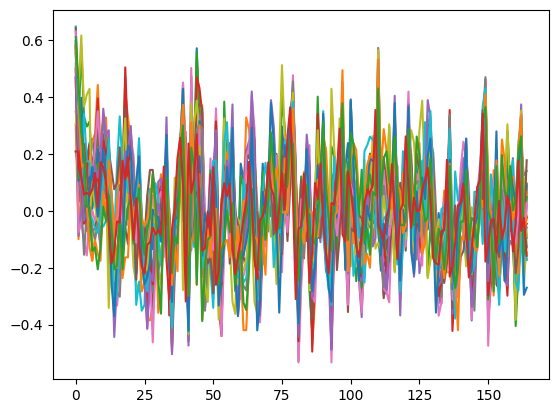

In [ ]:
plt.plot(current_df)

# Tests with a Window Generator (does not work yet)

In [ ]:
from keras.utils import Sequence

# Create the window function
def window(data, window_size):
  return data[-window_size:]

# Create the model
class WindowGenerator(Sequence):
  def __init__(self, data, window_size, batch_size):
    self.data = data
    self.window_size = window_size
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.data) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = min(len(self.data), start + self.batch_size)
    return window(self.data[start:end], self.window_size)


In [ ]:
WindowGenerator(train_df, 10, 32)

NameError: ignored

In [ ]:
window_size = 10

# Create the model
model = Sequential()
model.add(LSTM(units=128, input_shape=(window_size,)))
model.add(Dense(units=10, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit_generator(WindowGenerator(train_df, 10, 32), epochs=10)

# Evaluate the model
model.evaluate(test_df[columns], test_df["target"])

ValueError: ignored

In [ ]:
# FUNCTION to convert an array of values into a dataset matrix (which will be created for each LSTM)
# X = t, while Y = t+1
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
voxel_list

['voxel_1',
 'voxel_2',
 'voxel_3',
 'voxel_4',
 'voxel_5',
 'voxel_6',
 'voxel_7',
 'voxel_8',
 'voxel_9',
 'voxel_10',
 'voxel_11',
 'voxel_12',
 'voxel_13',
 'voxel_14',
 'voxel_15',
 'voxel_16',
 'voxel_17',
 'voxel_18',
 'voxel_19',
 'voxel_20',
 'voxel_21',
 'voxel_22',
 'voxel_23']

In [ ]:
# Create the LSTM streams
lstm_streams = []

In [ ]:
for voxel in voxel_list:
  lstm_streams.append(LSTM(units=10, input_shape=(1, 10))) # df[voxel].shape[0],))), where 10 is the look_back_value
  print(lstm_streams[-1].input)

AttributeError: ignored

In [ ]:

# Create the dense layer
dense_layer = Dense(units=10, activation="softmax") # or activation "linear"? #units =number_hidden_neurons


In [ ]:
# Create the model
model = Sequential()

In [ ]:
for i in range(len(lstm_streams)):
  print(lstm_streams[i].input)

NameError: ignored

In [ ]:
lstm_streams[0].input

AttributeError: ignored

In [ ]:
lstm_streams[-1].input

In [ ]:
# model.add(LSTM(units=128, input_shape=(df[voxel[0]].shape[1],)))
# for lstm_stream in lstm_streams[1:]:
for lstm_stream in lstm_streams:
    model.add(lstm_stream)
model.add(dense_layer)


In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(df[voxel], df["target"], epochs=10)

# Evaluate the model
model.evaluate(df[voxel], df["target"])

This code will create a model with 23 parallel LSTM streams, each of which will work on a different column of the dataframe. The output of the LSTM streams will be concatenated and fed into a dense layer. The dense layer will then output a prediction for the target variable. The model can be trained and evaluated using the standard Keras API.

# Trial 1: 3 LSTMs with 128 neurons on one voxel (works)



In [ ]:
voxel_1_arr = np.reshape(np.array(current_df['voxel_1']), (len(current_df['voxel_1']),1))
voxel_2_arr = np.reshape(np.array(current_df['voxel_2']), (len(current_df['voxel_2']),1))
voxel_3_arr = np.reshape(np.array(current_df['voxel_3']), (len(current_df['voxel_3']),1))

In [ ]:
# voxel_1_arr

In [ ]:
# FUNCTION to convert an array of values into a dataset matrix
# X = t, while Y = t+1
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
vox_1_X, vox_1_y = create_dataset(voxel_1_arr, look_back)
vox_2_X, vox_2_y = create_dataset(voxel_2_arr, look_back)
vox_3_X, vox_3_y = create_dataset(voxel_3_arr, look_back)

In [ ]:
# vox_1_X

In [ ]:
# vox_1_y

In [ ]:
train_1_dx = np.diff(vox_1_X, axis=0)
train_2_dx = np.diff(vox_1_X, axis=0)
train_3_dx = np.diff(vox_1_X, axis=0)

In [ ]:
# reshape input to be [samples, time steps, features]
vox_1_X_reshaped = np.reshape(vox_1_X, (vox_1_X.shape[0], 1, vox_1_X.shape[1]))
vox_1_dX_reshaped = np.reshape(train_1_dx, (train_1_dx.shape[0], 1, train_1_dx.shape[1]))

vox_2_X_reshaped = np.reshape(vox_2_X, (vox_2_X.shape[0], 1, vox_2_X.shape[1]))
vox_2_dX_reshaped = np.reshape(train_2_dx, (train_2_dx.shape[0], 1, train_2_dx.shape[1]))

vox_3_X_reshaped = np.reshape(vox_3_X, (vox_3_X.shape[0], 1, vox_3_X.shape[1]))
vox_3_dX_reshaped = np.reshape(train_3_dx, (train_3_dx.shape[0], 1, train_3_dx.shape[1]))

In [ ]:
# vox_1_X_reshaped

In [ ]:
# split into train and test sets
train_size = int(len(current_df) * 0.70)
test_size = len(current_df) - train_size

In [ ]:
# vox_1_X_reshaped.size

In [ ]:
# vox_1_X_reshaped[0:train_size,:].size

In [ ]:
# current_df.iloc[:train_size]

In [ ]:
len(vox_1_X_reshaped)

154

In [ ]:
len(df)

165

In [ ]:
# CHECK IF THIS REALLY WORKS AS PLANNED!
train_vox_1_X, test_vox_1_X = vox_1_X_reshaped[0:train_size,:], vox_1_X_reshaped[train_size:len(vox_1_X_reshaped),:]
train_vox_1_y, test_vox_1_y = vox_1_y[0:train_size], vox_1_y[train_size:len(vox_1_X_reshaped)]
train_vox_1_dX, test_vox_1_dX = vox_1_dX_reshaped[0:train_size,:], vox_1_dX_reshaped[train_size:len(vox_1_X_reshaped),:]

In [ ]:
train_vox_2_X, test_vox_2_X = vox_2_X_reshaped[0:train_size,:], vox_2_X_reshaped[train_size:len(vox_2_X_reshaped),:]
train_vox_2_y, test_vox_2_y = vox_2_y[0:train_size], vox_2_y[train_size:len(vox_2_X_reshaped)]
train_vox_2_dX, test_vox_2_dX = vox_2_dX_reshaped[0:train_size,:], vox_2_dX_reshaped[train_size:len(vox_2_X_reshaped),:]

In [ ]:
train_vox_3_X, test_vox_3_X = vox_3_X_reshaped[0:train_size,:], vox_3_X_reshaped[train_size:len(vox_2_X_reshaped),:]
train_vox_3_y, test_vox_3_y = vox_3_y[0:train_size], vox_2_y[train_size:len(vox_2_X_reshaped)]
train_vox_3_dX, test_vox_3_dX = vox_3_dX_reshaped[0:train_size,:], vox_3_dX_reshaped[train_size:len(vox_2_X_reshaped),:]

In [ ]:
train_vox_1_X

array([[[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
          0.31141959,  0.12301379]],

       [[ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
          0.12301379,  0.19547756]],

       [[ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
          0.19547756,  0.26794133]],

       ...,

       [[-0.19582679, -0.16684128,  0.22446307, ...,  0.02156452,
          0.13750655,  0.12301379]],

       [[-0.16684128,  0.22446307,  0.02156452, ...,  0.13750655,
          0.12301379,  0.07953553]],

       [[ 0.22446307,  0.02156452, -0.18133403, ...,  0.12301379,
          0.07953553, -0.05089925]]])

In [ ]:
train_vox_1_y

array([ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
       -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
        0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
       -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
       -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
       -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
       -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
        0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
       -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
        0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
        0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
       -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
        0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
        0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20

In [ ]:
# len(train_vox_1_X)

In [ ]:
# len(train_vox_1_y)

In [ ]:
# len(test_vox_1_X)

In [ ]:
# len(test_vox_1_y)

LSTM stuff without derivative!

In [ ]:
# create and fit the LSTM network. Until now without derivative!
model1 = Sequential()
model1.add(LSTM(128, input_shape=(1, look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(train_vox_1_X, train_vox_1_y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# create and fit the LSTM network. Until now without derivative!
model2 = Sequential()
model2.add(LSTM(128, input_shape=(1, look_back)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(train_vox_2_X, train_vox_2_y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# create and fit the LSTM network. Until now without derivative!
model3 = Sequential()
model3.add(LSTM(128, input_shape=(1, look_back)))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(train_vox_3_X, train_vox_3_y, epochs=100, batch_size=1, verbose=2)

# model.fit(vox_1_X_reshaped, vox_1_y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# make predictions
pred_train_vox_1 = model1.predict(train_vox_1_X)
pred_test_vox_1 = model1.predict(test_vox_1_X)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# make predictions
pred_train_vox_2 = model1.predict(train_vox_2_X)
pred_test_vox_2 = model1.predict(test_vox_2_X)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# make predictions
pred_train_vox_3 = model1.predict(train_vox_3_X)
pred_test_vox_3 = model1.predict(test_vox_3_X)

2/2 [==============================] - 0s 6ms/step


In [ ]:
def plot_true_ts_vs_prediction(voxel_arr, test_vox_y, pred_train_vox, pred_test_vox): # inputs: full_y_arr, true_y, pred_train, pred_test
    # Evaluation: Mean squared error and R-squared
    mse = mean_squared_error(test_vox_y, pred_test_vox)
    r2 = r2_score(test_vox_y, pred_test_vox)

    print("Mean squared error:", mse)
    print("R-squared:", r2)

    # Plot scatter plot of predicted versus actual values
    plt.scatter(test_vox_y, pred_test_vox, alpha=0.5, color='gray')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', color='red')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    # plt.title('Regression results\nMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(mse, mae, r2))
    plt.title('Regression results\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
    plt.show()

    plt.plot(voxel_arr) #[train_vox_y, test_vox_y])?? Why does that not work?

    # pred_train_vox
    c = np.empty_like(voxel_arr) #[train_vox_y, test_vox_y])
    c[:] = np.nan
    c[look_back:train_size+look_back] = pred_train_vox.reshape(len(pred_train_vox),1)
    plt.plot(c)

    # pred_test_vox
    d = np.empty_like(voxel_arr) #[train_vox_y, test_vox_y])
    d[:] = np.nan
    d[look_back+train_size:-1] = pred_test_vox_1.reshape(len(pred_test_vox),1)
    plt.plot(d, 'black')

Mean squared error: 0.02055028461718006
R-squared: -0.5091829665527647


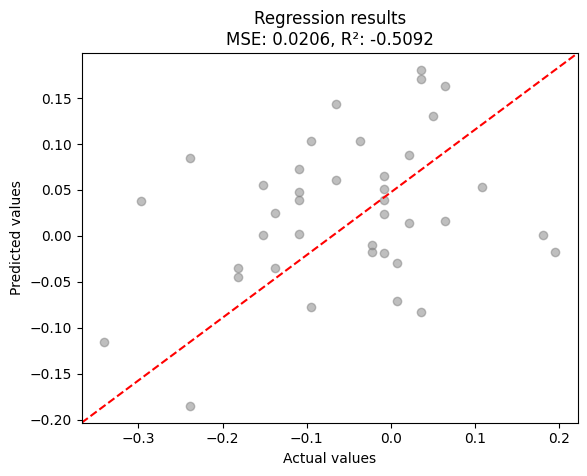

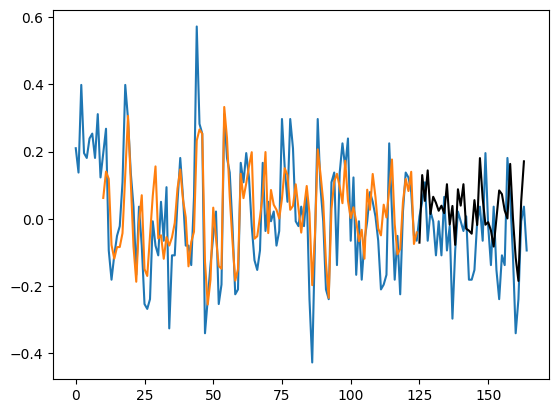

In [ ]:
plot_true_ts_vs_prediction(voxel_1_arr, test_vox_1_y, pred_train_vox_1, pred_test_vox_1)

Mean squared error: 0.03470658781098742
R-squared: -0.3780312206136687


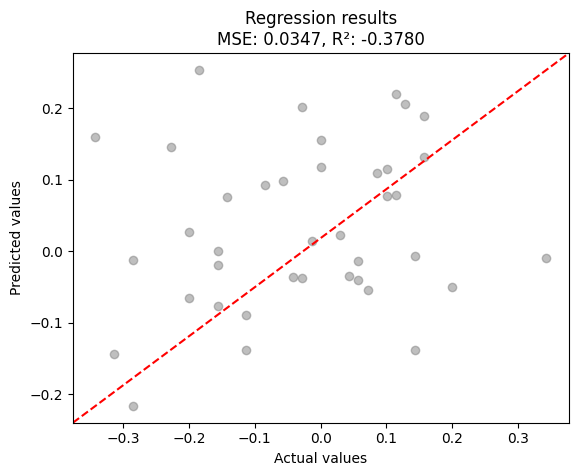

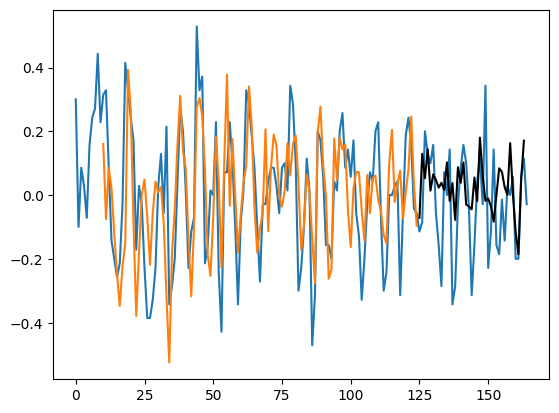

In [ ]:
plot_true_ts_vs_prediction(voxel_2_arr, test_vox_2_y, pred_train_vox_2, pred_test_vox_2)

Mean squared error: 0.026377533179782014
R-squared: -0.0473246301961483


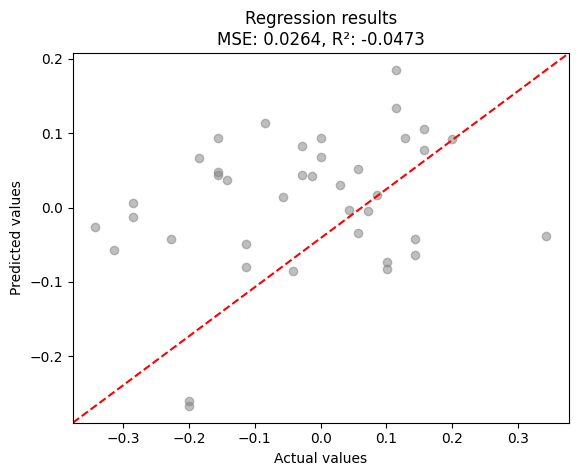

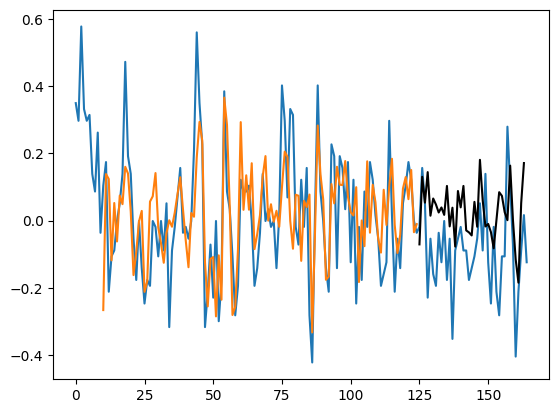

In [ ]:
plot_true_ts_vs_prediction(voxel_3_arr, test_vox_3_y, pred_train_vox_3, pred_test_vox_3)

Now: We have 3 pretrained (even if badly) LSTMs, now I want to combine the results.

In [ ]:
train_vox_1_y

array([ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
       -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
        0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
       -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
       -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
       -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
       -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
        0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
       -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
        0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
        0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
       -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
        0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
        0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20

In [ ]:
final_layer_train_X = np.hstack((pred_train_vox_1, pred_train_vox_2, pred_train_vox_3))
final_layer_test_X = np.hstack((pred_test_vox_1, pred_test_vox_2, pred_test_vox_3))

In [ ]:
final_layer_train_X

In [ ]:
final_layer_train_X_reshaped = np.reshape(final_layer_train_X, (final_layer_train_X.shape[0], 1, final_layer_train_X.shape[1]))
final_layer_test_X_reshaped = np.reshape(final_layer_test_X, (final_layer_test_X.shape[0], 1, final_layer_test_X.shape[1]))

In [ ]:
final_layer_test_X_reshaped

array([[[-0.07106254, -0.13844231, -0.08030614]],

       [[ 0.13002682,  0.09278709,  0.11321416]],

       [[ 0.05315015, -0.04977161,  0.0916188 ]],

       [[ 0.14401583,  0.20588115,  0.09350843]],

       [[ 0.0142863 ,  0.11494295, -0.07302174]],

       [[ 0.06544478,  0.13192822,  0.07693508]],

       [[ 0.04761368,  0.09756333,  0.0137239 ]],

       [[ 0.0238515 , -0.01889951,  0.04386313]],

       [[ 0.03881044, -0.01283704,  0.00675908]],

       [[ 0.0167312 , -0.05465108, -0.00515395]],

       [[ 0.10285676,  0.11778907,  0.0682693 ]],

       [[-0.01753503, -0.00649522, -0.06342987]],

       [[ 0.03812557,  0.15927407, -0.02635524]],

       [[-0.07761952, -0.21668816, -0.01304525]],

       [[ 0.08777722, -0.03805442,  0.08326488]],

       [[ 0.0391345 ,  0.10898948,  0.01686722]],

       [[ 0.10285757,  0.18881503,  0.10588361]],

       [[-0.02945293,  0.07676539, -0.08234647]],

       [[-0.03528871, -0.03575912, -0.08510017]],

       [[-0.04443797, -0.143651

In [ ]:
train_mean_array = (train_vox_1_y+train_vox_2_y+train_vox_3_y)/3.0
test_mean_array = (test_vox_1_y+test_vox_2_y+test_vox_3_y)/3.0

In [ ]:
final_layer_train_X_reshaped

array([[[ 6.19902387e-02,  1.60463303e-01, -2.66575992e-01]],

       [[ 1.40556306e-01, -7.48764426e-02,  1.38197094e-01]],

       [[ 1.18622720e-01,  8.57300460e-02,  1.23476282e-01]],

       [[-7.80752897e-02,  2.20860727e-02, -1.18625939e-01]],

       [[-1.18881151e-01, -1.19586393e-01,  5.20773530e-02]],

       [[-8.45288038e-02, -2.46477872e-01, -6.23384342e-02]],

       [[-8.40337723e-02, -3.47267538e-01,  7.43169934e-02]],

       [[-4.27187905e-02, -2.23855674e-01,  4.86089662e-02]],

       [[ 1.31313518e-01, -1.51087284e-01,  1.59869015e-01]],

       [[ 3.06169182e-01,  3.93051028e-01,  1.39831185e-01]],

       [[ 1.09775558e-01,  2.64372706e-01,  2.61652991e-02]],

       [[-8.28327611e-02, -9.12445486e-02, -1.62404984e-01]],

       [[-1.87448800e-01, -3.78694206e-01, -9.30790454e-02]],

       [[-1.03345746e-02, -1.82299405e-01, -2.78072897e-03]],

       [[ 7.00901598e-02,  6.70659356e-04,  2.85335630e-02]],

       [[-1.49588048e-01,  4.87309471e-02, -2.12315679e

In [ ]:
# Combine the predictions of the three LSTM models
pred_train_vox_1

from keras.layers import Flatten
# Train a final model using the combined predictions
final_model = Sequential()
final_model.add(Dense(64, activation='relu', input_shape=(1, 3)))
final_model.add(Dense(1))
final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.fit(final_layer_train_X_reshaped, train_mean_array, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
115/115 - 1s - loss: 0.0206 - 1s/epoch - 9ms/step
Epoch 2/100
115/115 - 0s - loss: 0.0162 - 133ms/epoch - 1ms/step
Epoch 3/100
115/115 - 0s - loss: 0.0155 - 139ms/epoch - 1ms/step
Epoch 4/100
115/115 - 0s - loss: 0.0150 - 132ms/epoch - 1ms/step
Epoch 5/100
115/115 - 0s - loss: 0.0148 - 134ms/epoch - 1ms/step
Epoch 6/100
115/115 - 0s - loss: 0.0145 - 133ms/epoch - 1ms/step
Epoch 7/100
115/115 - 0s - loss: 0.0144 - 183ms/epoch - 2ms/step
Epoch 8/100
115/115 - 0s - loss: 0.0146 - 197ms/epoch - 2ms/step
Epoch 9/100
115/115 - 0s - loss: 0.0140 - 199ms/epoch - 2ms/step
Epoch 10/100
115/115 - 0s - loss: 0.0142 - 192ms/epoch - 2ms/step
Epoch 11/100
115/115 - 0s - loss: 0.0138 - 191ms/epoch - 2ms/step
Epoch 12/100
115/115 - 0s - loss: 0.0141 - 196ms/epoch - 2ms/step
Epoch 13/100
115/115 - 0s - loss: 0.0140 - 199ms/epoch - 2ms/step
Epoch 14/100
115/115 - 0s - loss: 0.0139 - 193ms/epoch - 2ms/step
Epoch 15/100
115/115 - 0s - loss: 0.0135 - 202ms/epoch - 2ms/step
Epoch 16/100
115/115 -

In [ ]:
# Make predictions using the final model
final_predictions = final_model.predict(final_layer_test_X_reshaped)

2/2 [==============================] - 0s 6ms/step


Mean squared error: 0.026377533179782014
R-squared: -0.0473246301961483


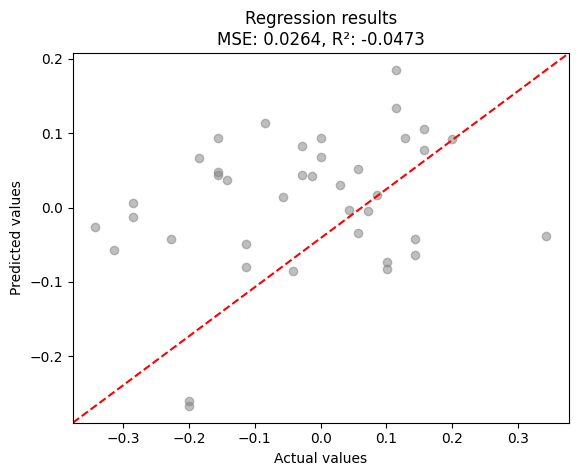

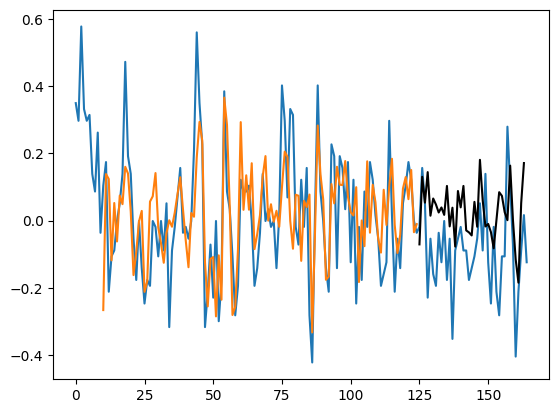

In [ ]:
plot_true_ts_vs_prediction(voxel_3_arr, test_vox_3_y, pred_train_vox_3, pred_test_vox_3)


# LSTM with 128 neurons on one voxel


In [ ]:
# current_df['voxel_1'].to_numpy().reshape(
voxel_1_arr = np.reshape(np.array(current_df['voxel_1']), (len(current_df['voxel_1']),1))
# np.array(current_df['voxel_1]) #).reshape[1,:]

In [ ]:
voxel_1_arr

In [ ]:
# FUNCTION to convert an array of values into a dataset matrix
# X = t, while Y = t+1
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
vox_1_X, vox_1_y = create_dataset(voxel_1_arr, look_back) #np.array(current_df['voxel_1']), look_back)

# voxel_1_df
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

In [ ]:
vox_1_X

array([[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
         0.31141959,  0.12301379],
       [ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
         0.12301379,  0.19547756],
       [ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
         0.19547756,  0.26794133],
       ...,
       [-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
        -0.10887026, -0.34075432],
       [ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
        -0.34075432, -0.23930505],
       [-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
        -0.23930505, -0.00742099]])

In [ ]:
vox_1_y

array([ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
       -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
        0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
       -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
       -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
       -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
       -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
        0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
       -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
        0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
        0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
       -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
        0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
        0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20

In [ ]:
train_dx = np.diff(vox_1_X, axis=0)

In [ ]:
# reshape input to be [samples, time steps, features]
vox_1_X_reshaped = np.reshape(vox_1_X, (vox_1_X.shape[0], 1, vox_1_X.shape[1]))
vox_1_dX_reshaped = np.reshape(train_dx, (train_dx.shape[0], 1, train_dx.shape[1]))

In [ ]:
vox_1_X_reshaped

array([[[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
          0.31141959,  0.12301379]],

       [[ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
          0.12301379,  0.19547756]],

       [[ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
          0.19547756,  0.26794133]],

       ...,

       [[-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
         -0.10887026, -0.34075432]],

       [[ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
         -0.34075432, -0.23930505]],

       [[-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
         -0.23930505, -0.00742099]]])

In [ ]:
# split into train and test sets
train_size = int(len(current_df) * 0.70)
test_size = len(current_df) - train_size

In [ ]:
vox_1_X_reshaped.size

1540

In [ ]:
vox_1_X_reshaped[0:train_size,:].size

1150

In [ ]:
# current_df.iloc[:train_size]

In [ ]:
# CHECK IF THIS REALLY WORKS AS PLANNED!
train_vox_1_X, test_vox_1_X = vox_1_X_reshaped[0:train_size,:], vox_1_X_reshaped[train_size:len(df),:]
train_vox_1_y, test_vox_1_y = vox_1_y[0:train_size], vox_1_y[train_size:len(df)]
train_vox_1_dX, test_vox_1_dX = vox_1_dX_reshaped[0:train_size,:], vox_1_dX_reshaped[train_size:len(df),:]

# print(len(train_df), len(test_df))

# train_df, test_df = current_df.iloc[:train_size], current_df[train_size:len(df)]
# print(len(train_df), len(test_df))

# train_df, test_df = train_test_split(df, test_size=0.2) # AS Alternative

In [ ]:
len(train_vox_1_X)

115

In [ ]:
len(train_vox_1_y)

115

In [ ]:
len(test_vox_1_X)

39

In [ ]:
len(test_vox_1_y)

39

LSTM stuff without derivative!

In [ ]:
# create and fit the LSTM network. Until now without derivative!
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(vox_1_X_reshaped, vox_1_y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# make predictions
pred_train_vox_1 = model.predict(train_vox_1_X)
pred_test_vox_1 = model.predict(test_vox_1_X)

# invert predictions (WORKS! JUST COMMENTED OUT FOR BETTER COMPARISON WITH OTHER ARCHITECTURES!)
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

# # calculate root mean squared error
# trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Evaluation: Mean squared error and R-squared
mse = mean_squared_error(test_vox_1_y, pred_test_vox_1)
r2 = r2_score(test_vox_1_y, pred_test_vox_1)

print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 0.012475348128773175
R-squared: 0.08382860634346112


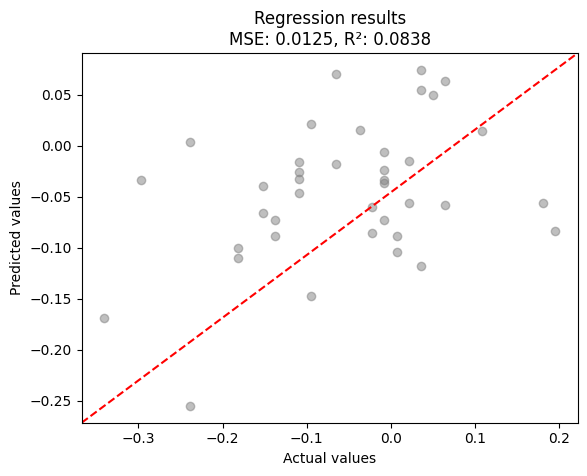

In [ ]:
# Plot scatter plot of predicted versus actual values
plt.scatter(test_vox_1_y, pred_test_vox_1, alpha=0.5, color='gray')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.title('Regression results\nMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(mse, mae, r2))
plt.title('Regression results\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.show()

In [ ]:
train_vox_1_y

array([ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
       -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
        0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
       -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
       -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
       -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
       -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
        0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
       -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
        0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
        0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
       -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
        0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
        0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20

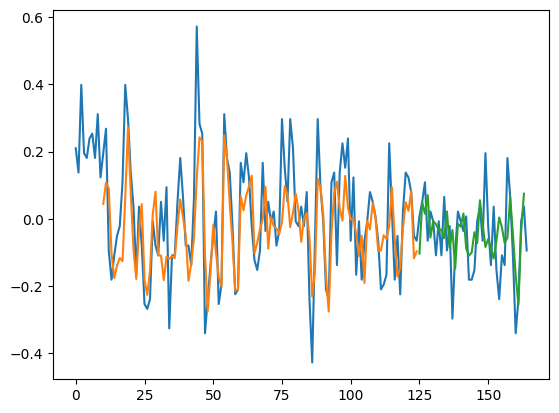

In [ ]:
plt.plot(voxel_1_arr)

# # train_vox_1_y
# a = np.empty_like(voxel_1_arr)
# a[:] = np.nan
# a[look_back:train_size+look_back] = train_vox_1_y.reshape(len(train_vox_1_y),1)
# plt.plot(a)

# # test_vox_1_y
# b = np.empty_like(voxel_1_arr)
# b[:] = np.nan
# b[look_back+train_size:-1] = test_vox_1_y.reshape(len(test_vox_1_y),1)
# plt.plot(b)

# pred_train_vox_1
c = np.empty_like(voxel_1_arr)
c[:] = np.nan
c[look_back:train_size+look_back] = pred_train_vox_1.reshape(len(pred_train_vox_1),1)
plt.plot(c)

# pred_test_vox_1
d = np.empty_like(voxel_1_arr)
d[:] = np.nan
d[look_back+train_size:-1] = pred_test_vox_1.reshape(len(pred_test_vox_1),1)
plt.plot(d)

In [ ]:

test_dataframes = []


dg_test = pd.DataFrame()

In [ ]:
# Create an empty array to store the final dataframes
train_dataframes = []

look_back = 10

for voxels in voxel_list:
    # Create a new dataframe with the current column
    train_dataframes_X = pd.DataFrame()
    train_dataframes_y = pd.DataFrame()

for i in range(len(train_dataframes)-look_back-1):
  train_dataframes_X.append(train_dataframes[i].loc(i)) #[i:(i+look_back), 0])
  train_dataframes_y.append(train_dataframes[i].loc(i+1)) #[i + look_back, 0])

print(train_dataframes_X)

# # reshape into X=t and Y=t+1
# look_back = 10
# trainX, trainY = create_dataset(train_df[voxel], look_back)
# testX, testY = create_dataset(test_df[voxel], look_back)

Empty DataFrame
Columns: []
Index: []


In [ ]:
train_dataframes = np.array([])

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX_array = []
trainY_array = []
testX_array = []
testY_array = []

for i in range(len(train_dataframes)-1):
  trainX_array[i], trainY_array[i] = create_dataset(train_dataframes[i], look_back)
  testX_array[i], testY_array[i] = create_dataset(test_dataframes[i], look_back)

In [ ]:
trainX_array

[]

# Combining LSTMs of multiple (23) voxels

In [ ]:
print(range(len(voxel_list)-1))

range(0, 22)


In [ ]:
voxel_list[22]

'voxel_23'

In [ ]:
# current_df['voxel_1'].to_numpy().reshape(
voxel_arrays = [] # includes voxel_1_arr, voxel_2_arr, ....
for voxel in voxel_list: # i in range(len(voxel_list)-1):
  array = np.reshape(np.array(current_df[voxel]), (len(current_df[voxel]),1))
  voxel_arrays.append(array)

  #voxel_arrays[i] = np.reshape(np.array(current_df[voxel_list[i]]), (len(current_df[voxel_list[i]]),1))


In [ ]:
len(voxel_arrays[0])

165

In [ ]:
voxel_arrays[0] #; identical to previous voxel_1_arr

array([[ 0.20997032],
       [ 0.13750655],
       [ 0.39837611],
       [ 0.19547756],
       [ 0.18098481],
       [ 0.23895582],
       [ 0.25344858],
       [ 0.18098481],
       [ 0.31141959],
       [ 0.12301379],
       [ 0.19547756],
       [ 0.26794133],
       [-0.09437751],
       [-0.18133403],
       [-0.10887026],
       [-0.05089925],
       [-0.02191374],
       [ 0.10852104],
       [ 0.39837611],
       [ 0.29692684],
       [ 0.13750655],
       [ 0.03605727],
       [-0.16684128],
       [ 0.03605727],
       [-0.07988476],
       [-0.2537978 ],
       [-0.26829055],
       [-0.23930505],
       [-0.00742099],
       [-0.07988476],
       [-0.10887026],
       [ 0.05055003],
       [-0.065392  ],
       [ 0.09402829],
       [-0.32626157],
       [-0.10887026],
       [-0.10887026],
       [ 0.05055003],
       [ 0.18098481],
       [ 0.06504278],
       [-0.07988476],
       [-0.07988476],
       [-0.13785577],
       [ 0.06504278],
       [ 0.57228916],
       [ 0

In [ ]:
# FUNCTION to convert an array of values into a dataset matrix
# X = t, while Y = t+1
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10

vox_X_arrays = []
vox_y_arrays = []
for voxel_id in range(len(voxel_list)-1):
  vox_curr_X, vox_curr_y = create_dataset(voxel_arrays[voxel_id], look_back) #np.array(current_df['voxel_1']), look_back)
  vox_X_arrays.append(vox_curr_X)
  vox_y_arrays.append(vox_curr_y)

# voxel_1_df
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

In [ ]:
vox_X_arrays

[array([[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
          0.31141959,  0.12301379],
        [ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
          0.12301379,  0.19547756],
        [ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
          0.19547756,  0.26794133],
        ...,
        [-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
         -0.10887026, -0.34075432],
        [ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
         -0.34075432, -0.23930505],
        [-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
         -0.23930505, -0.00742099]]),
 array([[ 0.30051635, -0.09948365,  0.08623064, ...,  0.27194492,
          0.44337349,  0.22908778],
        [-0.09948365,  0.08623064,  0.02908778, ...,  0.44337349,
          0.22908778,  0.31480207],
        [ 0.08623064,  0.02908778, -0.07091222, ...,  0.22908778,
          0.31480207,  0.32908778],
        ...,
        [-0.11376936,  0.14337349, -0.15662651, ...,  

In [ ]:
vox_X_arrays[0] # should be the same as vox_1_X

array([[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
         0.31141959,  0.12301379],
       [ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
         0.12301379,  0.19547756],
       [ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
         0.19547756,  0.26794133],
       ...,
       [-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
        -0.10887026, -0.34075432],
       [ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
        -0.34075432, -0.23930505],
       [-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
        -0.23930505, -0.00742099]])

In [ ]:
vox_y_arrays[0] # should be the same as vox_1_y

array([ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
       -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
        0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
       -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
       -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
       -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
       -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
        0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
       -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
        0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
        0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
       -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
        0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
        0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20

In [ ]:
dx_arrays = []

for voxel_id in range(len(voxel_list)-1):
  dx_arrays.append(np.diff(vox_X_arrays[voxel_id], axis=0))

# train_dx = np.diff(vox_1_X, axis=0)

In [ ]:
dx_arrays[0]

array([[-0.07246377,  0.26086957, -0.20289855, ...,  0.13043478,
        -0.1884058 ,  0.07246377],
       [ 0.26086957, -0.20289855, -0.01449275, ..., -0.1884058 ,
         0.07246377,  0.07246377],
       [-0.20289855, -0.01449275,  0.05797101, ...,  0.07246377,
         0.07246377, -0.36231884],
       ...,
       [-0.11594203,  0.17391304, -0.1884058 , ..., -0.11594203,
        -0.17391304, -0.23188406],
       [ 0.17391304, -0.1884058 , -0.08695652, ..., -0.17391304,
        -0.23188406,  0.10144928],
       [-0.1884058 , -0.08695652,  0.13043478, ..., -0.23188406,
         0.10144928,  0.23188406]])

In [ ]:
# reshape input to be [samples, time steps, features]

vox_X_reshaped_arrays = []
vox_dX_reshaped_arrays = []

for voxel_id in range(len(voxel_list)-1):
  vox_X_reshaped_arrays.append(np.reshape(vox_X_arrays[voxel_id],
                               (vox_X_arrays[voxel_id].shape[0], 1, vox_X_arrays[voxel_id].shape[1])))
  vox_dX_reshaped_arrays.append(np.reshape(dx_arrays[voxel_id],
                               (dx_arrays[voxel_id].shape[0], 1, dx_arrays[voxel_id].shape[1])))
# vox_1_X_reshaped = np.reshape(vox_1_X, (vox_1_X.shape[0], 1, vox_1_X.shape[1]))
# vox_1_dX_reshaped = np.reshape(train_dx, (train_dx.shape[0], 1, train_dx.shape[1]))

In [ ]:
vox_X_reshaped_arrays #previously: vox_1_X_reshaped

[array([[[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
           0.31141959,  0.12301379]],
 
        [[ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
           0.12301379,  0.19547756]],
 
        [[ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
           0.19547756,  0.26794133]],
 
        ...,
 
        [[-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
          -0.10887026, -0.34075432]],
 
        [[ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
          -0.34075432, -0.23930505]],
 
        [[-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
          -0.23930505, -0.00742099]]]),
 array([[[ 0.30051635, -0.09948365,  0.08623064, ...,  0.27194492,
           0.44337349,  0.22908778]],
 
        [[-0.09948365,  0.08623064,  0.02908778, ...,  0.44337349,
           0.22908778,  0.31480207]],
 
        [[ 0.08623064,  0.02908778, -0.07091222, ...,  0.22908778,
           0.31480207,  0.32908778]],
 
        ...,
 
       

In [ ]:
# split into train and test sets
train_size = int(len(current_df) * 0.70)
test_size = len(current_df) - train_size

In [ ]:
vox_X_reshaped_arrays[0][0][0]

array([0.20997032, 0.13750655, 0.39837611, 0.19547756, 0.18098481,
       0.23895582, 0.25344858, 0.18098481, 0.31141959, 0.12301379])

In [ ]:
train_size

115

In [ ]:
len(vox_X_reshaped_arrays[0])

154

In [ ]:
vox_X_reshaped_arrays[0].size #[train_size:len(vox_X_reshaped_arrays),:].size

1540

In [ ]:
train_size

115

In [ ]:
vox_X_reshaped_arrays[0][0:train_size] #this is basically the future train_X_arrays[0]

array([[[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
          0.31141959,  0.12301379]],

       [[ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
          0.12301379,  0.19547756]],

       [[ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
          0.19547756,  0.26794133]],

       ...,

       [[-0.19582679, -0.16684128,  0.22446307, ...,  0.02156452,
          0.13750655,  0.12301379]],

       [[-0.16684128,  0.22446307,  0.02156452, ...,  0.13750655,
          0.12301379,  0.07953553]],

       [[ 0.22446307,  0.02156452, -0.18133403, ...,  0.12301379,
          0.07953553, -0.05089925]]])

In [ ]:
# # CHECK IF THIS REALLY WORKS AS PLANNED!
# train_X_arrays = []
# train_y_arrays = []
# train_dX_arrays = []

# test_X_arrays = []
# test_y_arrays = []
# test_dX_arrays = []

# for voxel_id in range(len(voxel_list)-1):
#   train_X_arrays[voxel_id] = vox_X_reshaped_arrays[voxel_id][0:train_size]

#   print(voxel_id)
#   print(len(vox_X_reshaped_arrays[voxel_id][0:train_size,:]))
#   print(train_size)
#   print(vox_X_reshaped_arrays[voxel_id][0:train_size,:])
#   rows =  [[[ 0.20997032,  0.13750655,  0.39837611,  0.18098481,  0.31141959, 0.12301379]]]
# # Create a 3D array from the list of lists.
#   array = np.ndarray(rows)
#   train_X_arrays[voxel_id] = array
#   vox_X_reshaped_arrays[voxel_id][0:train_size,:]
#   test_X_arrays[voxel_id] = vox_X_reshaped_arrays[voxel_id][train_size:len(vox_X_reshaped_arrays[voxel_id]),:]

#   train_X_arrays[voxel_id], test_X_arrays[voxel_id] = vox_X_reshaped_arrays[voxel_id][0:train_size,:], vox_X_reshaped_arrays[voxel_id][train_size:len(vox_X_reshaped_arrays[voxel_id]),:]
#   train_y_arrays[voxel_id], test_y_arrays[voxel_id] = vox_y_arrays[voxel_id][0:train_size,:], vox_y_arrays[voxel_id][train_size:len(df),:]
#   train_dX_arrays[voxel_id], test_dX_arrays[voxel_id] = vox_dX_reshaped_arrays[voxel_id][0:train_size,:], vox_dX_reshaped_arrays[voxel_id][train_size:len(vox_dX_reshaped_arrays[voxel_id]),:]

# # train_vox_1_X, test_vox_1_X = vox_1_X_reshaped[0:train_size,:], vox_1_X_reshaped[train_size:len(df),:]
# # train_vox_1_y, test_vox_1_y = vox_1_y[0:train_size], vox_1_y[train_size:len(df)]
# # train_vox_1_dX, test_vox_1_dX = vox_1_dX_reshaped[0:train_size,:], vox_1_dX_reshaped[train_size:len(df),:]

In [ ]:
# len(train_X_arrays[0])

In [ ]:
# len(train_vox_1_y)

In [ ]:
# len(test_vox_1_X)

In [ ]:
# len(test_vox_1_y)

LSTM stuff without derivative!

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input

In [ ]:
# Assuming you have vox_X_arrays, vox_y_arrays, and mean_y_array as your data
# vox_X_arrays is a list of input data arrays
# vox_y_arrays is a list of corresponding output data arrays
# mean_y_array is a numpy array of true values for the combined prediction

# Define the number of LSTM units
num_units = 128

# Define the input shape
input_shape = (10,1)  # Adjust timesteps and input_dim according to your data

# Create a list to store individual LSTM models
lstms = []
outputs = []

# Create and train individual LSTMs
for i in range(22):
    # Create LSTM layer
    inputs = Input(shape=input_shape)
    lstm = LSTM(num_units)(inputs)
    lstms.append(Model(inputs=inputs, outputs=lstm))

    # Compile and train LSTM on respective data
    lstms[i].compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed
    lstms[i].fit(vox_X_arrays[i], vox_y_arrays[i], epochs=10, batch_size=32)  # Adjust epochs and batch_size as needed

    # Get the LSTM output for each input
    lstm_output = lstms[i](inputs)
    outputs.append(lstm_output)

# Concatenate the outputs of all LSTM models
concatenated = tf.keras.layers.concatenate(outputs)

Epoch 1/10
5/5 [==============================] - 2s 18ms/step - loss: 0.0262
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0262
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0262
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0261
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 0.0261
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0260
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0260
Epoch 8/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0260
Epoch 9/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0260
Epoch 10/10
5/5 [==============================] - 0s 20ms/step - loss: 0.0260
Epoch 1/10
5/5 [==============================] - 2s 16ms/step - loss: 0.0386
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0384
Epoch 3/10
5/5 [==============================] - 0s 15ms/step 

In [ ]:
# test_array = np.array([[ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
        -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
         0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
        -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
        -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
        -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
        -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
         0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
        -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
         0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
         0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
        -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
         0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
         0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20997032,
        -0.00742099, -0.02191374,  0.03605727, -0.02191374,  0.07953553,
        -0.23930505, -0.42771084, -0.065392  ,  0.29692684,  0.09402829,
        -0.00742099, -0.21031954, -0.23930505,  0.10852104,  0.13750655,
        -0.13785577,  0.13750655,  0.22446307,  0.1519993 ,  0.23895582,
        -0.065392  ,  0.12301379, -0.16684128, -0.00742099, -0.18133403,
        -0.065392  , -0.00742099,  0.07953553,  0.05055003,  0.00707177,
        -0.065392  , -0.21031954, -0.19582679, -0.16684128,  0.22446307,
         0.02156452, -0.18133403, -0.05089925, -0.22481229,  0.02156452,
         0.13750655,  0.12301379,  0.07953553, -0.05089925, -0.065392  ,
         0.00707177,  0.05055003,  0.10852104, -0.065392  ,  0.02156452,
        -0.00742099, -0.10887026, -0.00742099, -0.10887026,  0.06504278,
        -0.09437751, -0.02191374, -0.29727606, -0.09437751,  0.02156452,
        -0.00742099, -0.0364065 ,  0.00707177, -0.18133403, -0.18133403,
        -0.15234852, -0.00742099,  0.03605727, -0.065392  ,  0.19547756,
        -0.02191374, -0.13785577,  0.03605727, -0.15234852, -0.23930505,
        -0.10887026, -0.13785577,  0.18098481,  0.06504278, -0.10887026,
        -0.34075432, -0.23930505, -0.00742099,  0.03605727], [ 0.19547756,  0.26794133, -0.09437751, -0.18133403, -0.10887026,
        -0.05089925, -0.02191374,  0.10852104,  0.39837611,  0.29692684,
         0.13750655,  0.03605727, -0.16684128,  0.03605727, -0.07988476,
        -0.2537978 , -0.26829055, -0.23930505, -0.00742099, -0.07988476,
        -0.10887026,  0.05055003, -0.065392  ,  0.09402829, -0.32626157,
        -0.10887026, -0.10887026,  0.05055003,  0.18098481,  0.06504278,
        -0.07988476, -0.07988476, -0.13785577,  0.06504278,  0.57228916,
         0.28243408,  0.25344858, -0.34075432, -0.23930505, -0.13785577,
        -0.05089925,  0.02156452, -0.2537978 , -0.19582679,  0.31141959,
         0.18098481,  0.13750655, -0.02191374, -0.22481229, -0.21031954,
         0.16649206,  0.10852104,  0.19547756,  0.12301379, -0.02191374,
        -0.12336302, -0.15234852, -0.09437751,  0.16649206, -0.0364065 ,
         0.05055003, -0.00742099,  0.02156452, -0.07988476, -0.0364065 ,
         0.29692684,  0.1519993 ,  0.05055003,  0.29692684,  0.20997032,
        -0.00742099, -0.02191374,  0.03605727, -0.02191374,  0.07953553,
        -0.23930505, -0.42771084, -0.065392  ,  0.29692684,  0.09402829,
        -0.00742099, -0.21031954, -0.23930505,  0.10852104,  0.13750655,
        -0.13785577,  0.13750655,  0.22446307,  0.1519993 ,  0.23895582,
        -0.065392  ,  0.12301379, -0.16684128, -0.00742099, -0.18133403,
        -0.065392  , -0.00742099,  0.07953553,  0.05055003,  0.00707177,
        -0.065392  , -0.21031954, -0.19582679, -0.16684128,  0.22446307,
         0.02156452, -0.18133403, -0.05089925, -0.22481229,  0.02156452,
         0.13750655,  0.12301379,  0.07953553, -0.05089925, -0.065392  ,
         0.00707177,  0.05055003,  0.10852104, -0.065392  ,  0.02156452,
        -0.00742099, -0.10887026, -0.00742099, -0.10887026,  0.06504278,
        -0.09437751, -0.02191374, -0.29727606, -0.09437751,  0.02156452,
        -0.00742099, -0.0364065 ,  0.00707177, -0.18133403, -0.18133403,
        -0.15234852, -0.00742099,  0.03605727, -0.065392  ,  0.19547756,
        -0.02191374, -0.13785577,  0.03605727, -0.15234852, -0.23930505,
        -0.10887026, -0.13785577,  0.18098481,  0.06504278, -0.10887026,
        -0.34075432, -0.23930505, -0.00742099,  0.03605727]])

IndentationError: ignored

In [ ]:
# avg = np.mean(test_array, axis = 1)

In [ ]:
# avg

In [ ]:
len(vox_y_arrays[0])

154

In [ ]:
mean_y_array = np.mean(vox_y_arrays, axis=0)
len(mean_y_array)

154

In [ ]:
# Add a dense layer to combine the outputs
dense = Dense(units=1, activation='relu')(concatenated)  # Adjust units and activation as needed

# # Create the combined model
# combined_model = Model(inputs=inputs, outputs=dense)

# # Compile the combined model
# combined_model.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed

# # Train the combined model on mean_y_array
# combined_model.fit(vox_X_arrays[0], mean_y_array, epochs=10, batch_size=32)  # Adjust epochs and batch_size as needed

# # Make predictions with the combined model
# predictions = combined_model.predict(vox_X_arrays[0])  # Adjust input data as needed



# Create the combined model
combined_model = Model(inputs=[lstms[i].input for i in range(22)], outputs=dense)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed

# Prepare input data for the combined model
input_data = [vox_X_arrays[i] for i in range(22)]

# Train the combined model on mean_y_array
combined_model.fit(input_data, mean_y_array, epochs=, batch_size=32)  # Adjust epochs and batch_size as needed

# Make predictions with the combined model
predictions = combined_model.predict(input_data)


Epoch 1/10
5/5 [==============================] - 50s 604ms/step - loss: 0.0238
Epoch 2/10
5/5 [==============================] - 2s 451ms/step - loss: 0.0202
Epoch 3/10
5/5 [==============================] - 1s 230ms/step - loss: 0.0202
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.0202
Epoch 5/10
5/5 [==============================] - 1s 241ms/step - loss: 0.0202
Epoch 6/10
5/5 [==============================] - 1s 236ms/step - loss: 0.0202
Epoch 7/10
5/5 [==============================] - 2s 370ms/step - loss: 0.0202
Epoch 8/10
5/5 [==============================] - 3s 664ms/step - loss: 0.0202
Epoch 9/10
5/5 [==============================] - 2s 324ms/step - loss: 0.0202
Epoch 10/10
5/5 [==============================] - 10s 71ms/step


In [ ]:
mean_y_array

array([ 1.78879394e-01,  1.63285847e-01,  1.02123867e-01, -4.75716716e-02,
       -1.83351779e-01, -1.39554587e-01, -3.74942199e-02, -3.31046814e-02,
        1.87791429e-01,  1.16674892e-01,  1.93367494e-01,  4.48153585e-02,
       -1.07229234e-01,  4.37084396e-02, -1.12464195e-01, -1.97678770e-01,
       -2.27226198e-01, -1.23373905e-01, -1.20975436e-01, -6.29518615e-02,
       -7.54334307e-02, -5.38650669e-02, -8.78375782e-02,  1.58099322e-01,
       -1.75151065e-01, -3.13708895e-01, -6.59383037e-02,  1.91647440e-02,
        1.85578860e-01,  2.55454669e-01,  9.73248025e-02, -3.19562208e-01,
        2.38129328e-01,  5.92889338e-02,  1.27815054e-01,  2.78591195e-01,
        4.24337534e-02, -1.38095173e-01, -1.31499546e-01,  2.17389468e-03,
       -9.14632860e-02,  1.61751731e-01, -2.60187477e-01, -2.14486274e-01,
        4.60765170e-02,  1.02318358e-01,  5.84860947e-02,  9.89430888e-02,
       -1.14793252e-01, -2.25146268e-01, -1.57859268e-01, -9.32757278e-02,
       -1.01384920e-02,  

In [ ]:
input_data

[array([[ 0.20997032,  0.13750655,  0.39837611, ...,  0.18098481,
          0.31141959,  0.12301379],
        [ 0.13750655,  0.39837611,  0.19547756, ...,  0.31141959,
          0.12301379,  0.19547756],
        [ 0.39837611,  0.19547756,  0.18098481, ...,  0.12301379,
          0.19547756,  0.26794133],
        ...,
        [-0.13785577,  0.03605727, -0.15234852, ...,  0.06504278,
         -0.10887026, -0.34075432],
        [ 0.03605727, -0.15234852, -0.23930505, ..., -0.10887026,
         -0.34075432, -0.23930505],
        [-0.15234852, -0.23930505, -0.10887026, ..., -0.34075432,
         -0.23930505, -0.00742099]]),
 array([[ 0.30051635, -0.09948365,  0.08623064, ...,  0.27194492,
          0.44337349,  0.22908778],
        [-0.09948365,  0.08623064,  0.02908778, ...,  0.44337349,
          0.22908778,  0.31480207],
        [ 0.08623064,  0.02908778, -0.07091222, ...,  0.22908778,
          0.31480207,  0.32908778],
        ...,
        [-0.11376936,  0.14337349, -0.15662651, ...,  

In [ ]:
combined_model.layers[44].get_config()

{'name': 'concatenate', 'trainable': True, 'dtype': 'float32', 'axis': -1}

In [ ]:
# # Create a list of 23 LSTM models.
# lstm_models = []
# for _ in range(23):
#     lstm_models.append(tf.keras.models.Sequential([
#         tf.keras.layers.LSTM(units=128, return_sequences=True),
#         tf.keras.layers.Dense(units=10) # Needed, so that each LSTM can extract individual information
#     ]))

#     # Set the input dataframe for each LSTM model.
#     lstm_models.layers[0].input_shape = (10,) #vox_X_reshaped_arrays[0][0:train_size].shape[1],)

#     # Train each LSTM model on its own dataframe.
#     lstm_model.fit(vox_X_reshaped_arrays[i][0:train_size], epochs=10)

# # # Set the input dataframe for each LSTM model.
# # i = 0
# # # for i in range(len(vox_X_reshaped_arrays)):
# # for i, dataframe in enumerate(vox_X_reshaped_arrays[0][0:train_size]):
# #     lstm_models.layers[0].input_shape = (10,) #vox_X_reshaped_arrays[0][0:train_size].shape[1],)

# # Train each LSTM model on its own dataframe.
# i = 0
# for lstm_model in lstm_models:
#     lstm_model.fit(vox_X_reshaped_arrays[i][0:train_size], epochs=10)
#     i=i+1

# # Combine the predictions of the 23 LSTM models to get the final prediction.
# predictions = []
# for lstm_model in lstm_models:
#     predictions.append(lstm_model.predict(dataframe))

# # Get the final prediction by averaging the predictions of the 23 LSTM models.
# final_prediction = np.mean(predictions, axis=0)

In [ ]:
# # create and fit the LSTM network. Until now without derivative!
# model = Sequential()
# model.add(LSTM(128, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(vox_1_X_reshaped, vox_1_y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# # make predictions
# pred_train_vox_1 = model.predict(train_vox_1_X)
# pred_test_vox_1 = model.predict(test_vox_1_X)

# # invert predictions (WORKS! JUST COMMENTED OUT FOR BETTER COMPARISON WITH OTHER ARCHITECTURES!)
# # trainPredict = scaler.inverse_transform(trainPredict)
# # trainY = scaler.inverse_transform([trainY])
# # testPredict = scaler.inverse_transform(testPredict)
# # testY = scaler.inverse_transform([testY])

# # # calculate root mean squared error
# # trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# # print('Train Score: %.2f RMSE' % (trainScore))
# # testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# # print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
predictions

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
# Define the number of LSTM units
num_units = 128

# Define the input shape
input_shape = (10, 1)  # Adjust timesteps and input_dim according to your data

# Create a list to store individual LSTM models and predictions
lstms = []
predictions_lstms = []

# Create and train individual LSTMs
for i in range(22):
    # Create LSTM layer
    inputs = Input(shape=input_shape)
    lstm = LSTM(num_units)(inputs)
    lstms.append(Model(inputs=inputs, outputs=lstm))

    # Compile and train LSTM on respective data
    lstms[i].compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed
    lstms[i].fit(vox_X_arrays[i], vox_y_arrays[i], epochs=10, batch_size=32)  # Adjust epochs and batch_size as needed

    # Get the LSTM output for each input
    lstm_output = lstms[i](inputs)

    # Create a model to extract predictions from the LSTM output
    lstm_model = Model(inputs=inputs, outputs=lstm_output)

    # Store the predictions for the individual LSTM
    lstm_predictions = lstm_model.predict(vox_X_arrays[i])
    predictions_lstms.append(lstm_predictions)

# Print the predictions of the individual LSTMs
for i, lstm_predictions in enumerate(predictions_lstms):
    print(f"Predictions for LSTM {i+1}:")
    print(lstm_predictions)
    print()

# Note: You can modify the code above to save the predictions_lstms if needed.


In [ ]:
predictions_lstms

[array([[-0.02422038, -0.0282657 , -0.01421177, ..., -0.00561969,
          0.00081177, -0.02266679],
        [-0.0237156 , -0.02789247, -0.01393172, ..., -0.00563611,
          0.00076806, -0.02223774],
        [-0.0234546 , -0.02878811, -0.01312361, ..., -0.00377535,
          0.00284448, -0.02244292],
        ...,
        [-0.00785589, -0.00554931, -0.01348626, ..., -0.01967626,
         -0.02298259, -0.0068365 ],
        [-0.00621395, -0.0032651 , -0.01332507, ..., -0.02147647,
         -0.02504977, -0.00508406],
        [-0.0039827 , -0.00460091, -0.01025315, ..., -0.01584449,
         -0.01888339, -0.00487416]], dtype=float32),
 array([[-0.05075045, -0.04501216,  0.00982923, ..., -0.06659048,
         -0.06347941, -0.04947431],
        [-0.0492282 , -0.042348  ,  0.01314996, ..., -0.06656849,
         -0.0657443 , -0.04884946],
        [-0.06712479, -0.05915633,  0.00961074, ..., -0.08713785,
         -0.08336375, -0.06319445],
        ...,
        [ 0.01038122,  0.00927372, -0.0

In [ ]:
len(predictions_lstms[0])

154

## Current Stand

I do not understand why my LSTMs from the 23 LSTM network do not get the same predictions as the single LSTMs - I REALLY want to have a closer look at that. Also, WHY DOES THE FINAL DENSE LAYER JUST SET EVERYTHING TO ZERO? DOES IT TRAIN THE VALUES DIRECTLY TO ZERO?

In [ ]:
# Dense layer weights
combined_model.layers[45].weights[0].numpy()

array([[ 0.03335645],
       [-0.01371854],
       [-0.02612258],
       ...,
       [ 0.00885852],
       [-0.01847873],
       [ 0.02219626]], dtype=float32)

In [ ]:
len(combined_model.layers[45].weights[0].numpy())

2816

In [ ]:
# Concat Layer
combined_model.layers[44].input

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_2')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_3')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_4')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_5')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_6')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_7')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_8')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_9')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_10')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_11')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer

In [ ]:
combined_model.layers[44].output

<KerasTensor: shape=(None, 2816) dtype=float32 (created by layer 'concatenate')>

In [ ]:
model.layers[0]

In [ ]:
model.layers[1]

In [ ]:
# Assuming you want to get the weights of the second dense layer (index 1)
dense_layer = model.layers[1]
dense_weights = dense_layer.weights[0].numpy()
dense_biases = dense_layer.weights[1].numpy()

print("Weights:")
print(dense_weights)

print("Biases:")
print(dense_biases)

Weights:
[[-0.00334024]
 [ 0.13517039]
 [-0.00484993]
 [-0.12818219]
 [-0.2826907 ]
 [ 0.02235831]
 [-0.26182988]
 [ 0.00476115]
 [-0.14211313]
 [ 0.27503723]
 [-0.22344583]
 [-0.12301118]
 [ 0.06589932]
 [-0.18082197]
 [-0.29190597]
 [-0.28267816]
 [ 0.00310141]
 [ 0.00225885]
 [-0.1521149 ]
 [ 0.30224046]
 [ 0.3479268 ]
 [ 0.19779369]
 [-0.13317393]
 [ 0.16564666]
 [-0.00268273]
 [ 0.00624915]
 [-0.16977124]
 [ 0.1893339 ]
 [ 0.3027416 ]
 [ 0.00319854]
 [ 0.37958947]
 [-0.00200157]
 [-0.06994741]
 [-0.17913991]
 [ 0.30513495]
 [ 0.00473868]
 [ 0.00537444]
 [ 0.00566783]
 [-0.18520164]
 [-0.00371404]
 [ 0.11168484]
 [ 0.00132426]
 [-0.22364712]
 [-0.00181043]
 [-0.00541322]
 [ 0.28048742]
 [-0.01033373]
 [-0.03013212]
 [ 0.10866334]
 [ 0.07028668]
 [ 0.20825495]
 [-0.1188148 ]
 [ 0.09210738]
 [ 0.23102413]
 [-0.05697758]
 [-0.21137047]
 [ 0.0046969 ]
 [ 0.00343762]
 [-0.00063183]
 [-0.03877215]
 [ 0.06793536]
 [-0.04463586]
 [-0.21001355]
 [-0.11528908]
 [ 0.13692187]
 [-0.20207696]
 

In [ ]:
len(vox_y_arrays[0])

154

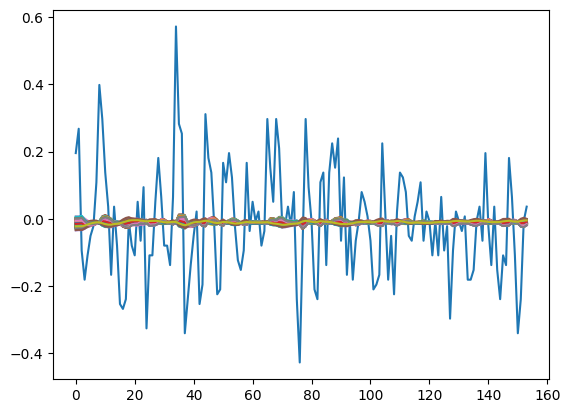

In [ ]:
plt.plot(vox_y_arrays[0])
plt.plot(predictions_lstms[0])

ValueError: ignored

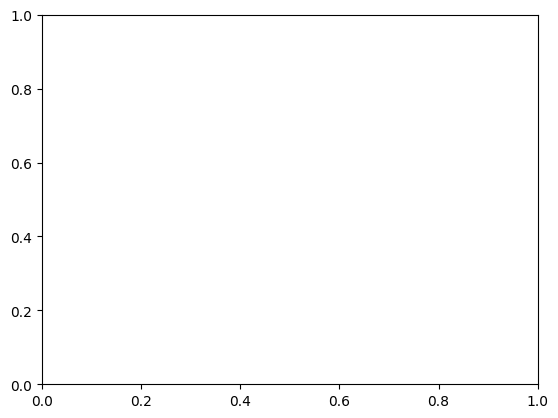

In [ ]:
# Plot scatter plot of predicted versus actual values
plt.scatter(vox_y_arrays[0], predictions_lstms[0][0], alpha=0.5, color='gray')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.title('Regression results\nMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(mse, mae, r2))
plt.title('Regression results\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.show()

In [ ]:
len(predictions)

154

In [ ]:
len(mean_y_array)

154

In [ ]:
predictions

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
# Evaluation: Mean squared error and R-squared
mse = mean_squared_error(mean_y_array, predictions)
r2 = r2_score(mean_y_array, predictions)

print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 0.02020331641707277
R-squared: -0.003523217291887093


In [ ]:
# Plot scatter plot of predicted versus actual values
plt.scatter(vox_y_array, predictions, alpha=0.5, color='gray')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.title('Regression results\nMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(mse, mae, r2))
plt.title('Regression results\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.show()

NameError: ignored

In [ ]:
# Plot scatter plot of predicted versus actual values
plt.scatter(mean_y_array, predictions, alpha=0.5, color='gray')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.title('Regression results\nMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(mse, mae, r2))
plt.title('Regression results\nMSE: {:.4f}, R²: {:.4f}'.format(mse, r2))
plt.show()

In [ ]:
plt.plot(mean_y_array)

# # train_vox_1_y
# a = np.empty_like(voxel_1_arr)
# a[:] = np.nan
# a[look_back:train_size+look_back] = train_vox_1_y.reshape(len(train_vox_1_y),1)
# plt.plot(a)

# # test_vox_1_y
# b = np.empty_like(voxel_1_arr)
# b[:] = np.nan
# b[look_back+train_size:-1] = test_vox_1_y.reshape(len(test_vox_1_y),1)
# plt.plot(b)

# pred_train_vox_1
# c = np.empty_like(mean_y_array)
# c[:] = np.nan
# c[look_back:train_size+look_back] = prediction_train.reshape(len(pred_train_vox_1),1)
# plt.plot(c)

# pred_test_vox_1
d = np.empty_like(mean_y_array)
d[:] = np.nan
# d[look_back+train_size:-1] = predictions.reshape(len(predictions),1)
d[len(mean_y_array)-len(predictions):] = predictions.reshape(len(predictions),)
plt.plot(d)

In [ ]:

# test_dataframes = []


# dg_test = pd.DataFrame()

In [ ]:
# # Create an empty array to store the final dataframes
# train_dataframes = []

# look_back = 10

# for voxels in voxel_list:
#     # Create a new dataframe with the current column
#     train_dataframes_X = pd.DataFrame()
#     train_dataframes_y = pd.DataFrame()

#     for i in range(len(train_df)-look_back-1):
#       train_dataframes_X.append(train_df.loc(i)) #[i:(i+look_back), 0])
#       train_dataframes_y.append(train_df.loc(i+1)) #[i + look_back, 0])

# print(train_dataframes_X)

# # # reshape into X=t and Y=t+1
# # look_back = 10
# # trainX, trainY = create_dataset(train_df[voxel], look_back)
# # testX, testY = create_dataset(test_df[voxel], look_back)

In [ ]:
train_dataframes = np.array([])

In [ ]:
# # # reshape into X=t and Y=t+1
# # look_back = 1
# # trainX, trainY = create_dataset(train_df, look_back)
# # testX, testY = create_dataset(test_df, look_back)


# # reshape into X=t and Y=t+1
# look_back = 10
# trainX_array = []
# trainY_array = []
# testX_array = []
# testY_array = []

# for i in range(len(train_dataframes)-1):
#   trainX_array[i], trainY_array[i] = create_dataset(train_dataframes[i], look_back)
#   testX_array[i], testY_array[i] = create_dataset(test_dataframes[i], look_back)